## 배터리 최적화(LP최적화)

### 데이터 전처리

In [1]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(formatter={'float': '{:0.5f}'.format})

import pandas as pd


# .mat 파일 로드
data = loadmat('pvLoadPriceData_test.mat')

# 데이터 추출 예시
# MATLAB 파일 내에 있는 변수 이름을 정확히 알아야 합니다. time, cloudyDay, clearDay, loadData, costData
time = data['time'].flatten().reshape(-1, 1)

cloudyDay = data['cloudyDay'].flatten().reshape(-1, 1)

clearDay = data['clearDay'].flatten().reshape(-1, 1)

loadData = data['loadData'][:, 2].reshape(-1, 1)

costData = data['costData'].flatten().reshape(-1, 1)

print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(cloudyDay), "차원" , cloudyDay.shape, )
print("자료형:", type(clearDay), "차원" , clearDay.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )



자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)


In [19]:
print(clearDay.tolist())
print(loadData.tolist())
print((loadData/1e3).tolist())

[[3.5], [3.51], [3.49], [3.45], [3.45], [3.47], [3.47], [3.49], [3.45], [3.45], [3.47], [3.47], [3.49], [3.47], [3.49], [3.53], [3.51], [3.6], [3.65], [3.6], [3.59], [3.75], [3.73], [3.84], [4.02], [4.73], [5.28], [6.0], [5.66], [4.64], [5.19], [5.06], [5.51], [5.89], [5.59], [5.33], [4.99], [5.56], [5.24], [5.45], [5.72], [6.28], [6.92], [4.85], [5.05], [8.43], [8.81], [8.82], [8.59], [8.76], [9.0], [8.19], [7.67], [8.88], [9.34], [10.95], [12.07], [11.68], [10.61], [12.84], [13.53], [15.55], [14.13], [12.35], [11.0], [12.86], [15.54], [18.81], [26.21], [21.06], [16.05], [16.67], [18.72], [21.59], [21.91], [29.52], [27.99], [30.51], [20.79], [30.33], [27.25], [29.01], [31.34], [37.24], [34.05], [27.81], [38.23], [41.67], [42.2], [37.33], [36.8], [42.25], [27.57], [29.14], [38.99], [35.36], [36.48], [23.63], [43.35], [29.62], [40.28], [44.77], [38.2], [17.87], [20.69], [29.04], [18.41], [17.97], [20.91], [19.41], [19.05], [17.08], [18.26], [18.16], [16.58], [17.82], [18.82], [13.54], [

### 데이터 처리

In [2]:
import numpy as np
import matlab.engine
import numpy as np

# Load Power Data from Existing PV array
# Assuming pvLoadPriceData is already loaded from file

# Set up Optimization Parameters
numDays = 1 # Number of consecutive days
FinalWeight = 1.0  # Final weight on energy storage
timeOptimize = 5  # Time step for optimization [min]

# Battery/PV parameters
panelArea = 2500
panelEff = 0.3

battEnergy = 2500 * 3.6e6
Einit = 0.5 * battEnergy
batteryMinMaxEmax = 0.8 * battEnergy
batteryMinMaxEmin = 0.2 * battEnergy
batteryMinMaxPmin = -400e3
batteryMinMaxPmax = 400e3

# Rescale data to align with desired time steps
stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))

cloudyPpv = panelArea * panelEff * np.tile(cloudyDay[1::stepAdjust], (numDays, 1))
clearPpv = panelArea * panelEff * np.tile(clearDay[1::stepAdjust], (numDays, 1))

# Adjust and Select Loading
loadSelect = 1
loadBase = 350e3
loadFluc = np.tile(loadData[1::stepAdjust], (numDays, 1)) + loadBase

# # Grid Price Values [$/kWh]
C = np.tile(costData[1::stepAdjust], (numDays, 1))

# Select Desired Data for Optimization
Ppv = clearPpv
# Ppv = cloudyPpv
Pload = loadFluc

# Setup Time Vectors
dt = timeOptimize * 60.0
N = numDays * (len(time[::stepAdjust]) - 1) * 1.0
tvec = np.arange(1, N + 1) * dt

print(type(N))
print(type(dt))
print(type(Ppv))
# NumPy 배열을 MATLAB으로 전달
Ppv = matlab.double(Ppv.tolist())
print(type(Pload))
# NumPy 배열을 MATLAB으로 전달
Pload = matlab.double(Pload.tolist())
print(type(Einit))
print(type(C))
# NumPy 배열을 MATLAB으로 전달
C = matlab.double(C.tolist())
print(type(FinalWeight))
print(type(batteryMinMaxEmax))
print(type(batteryMinMaxEmin))
print(type(batteryMinMaxPmin))
print(type(batteryMinMaxPmax))

# # MATLAB Engine 시작
eng = matlab.engine.start_matlab()

result = eng.battSolarOptimize(N, dt, Ppv, Pload, Einit, C, FinalWeight, batteryMinMaxEmax, batteryMinMaxEmin, batteryMinMaxPmin, batteryMinMaxPmax, nargout=3)
Pgrid = np.array(result[0])
Pbatt = np.array(result[1])
Ebatt = np.array(result[2])

eng.quit()

/var/folders/4j/gkyhxcv573j8gxl2r220cymm0000gn/T/ipykernel_9589/1429196818.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))


<class 'float'>
<class 'float'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'float'>
<class 'numpy.ndarray'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


### 그래프 출력

Text(0, 0.5, 'PV')

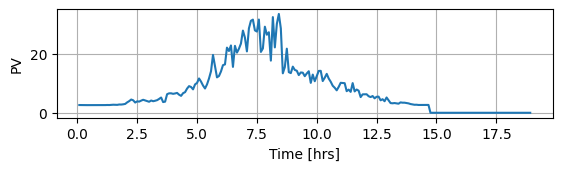

In [3]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Ppv * 1e-3)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('PV')

Text(0, 0.5, 'ESS')

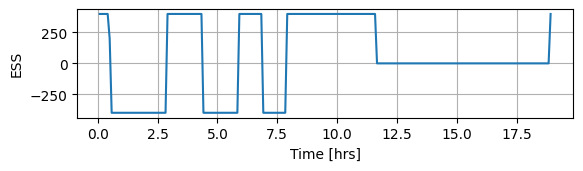

In [4]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Pbatt * 1e-3)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('ESS')

Text(0, 0.5, 'Grid')

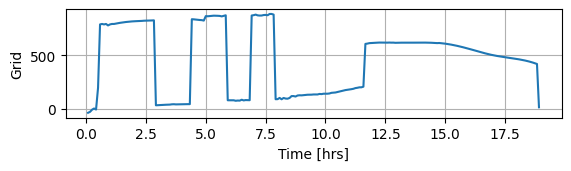

In [5]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Pgrid * 1e-3)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid')

Text(0, 0.5, 'Load')

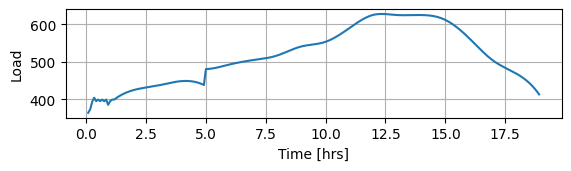

In [6]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Pload * 1e-3)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Load')

Text(0, 0.5, 'Grid Price [$/kWh]')

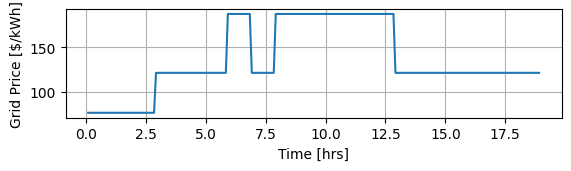

In [7]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)

plt.subplot(3, 1, 1)
# Assuming C is grid price
plt.plot(thour, C)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

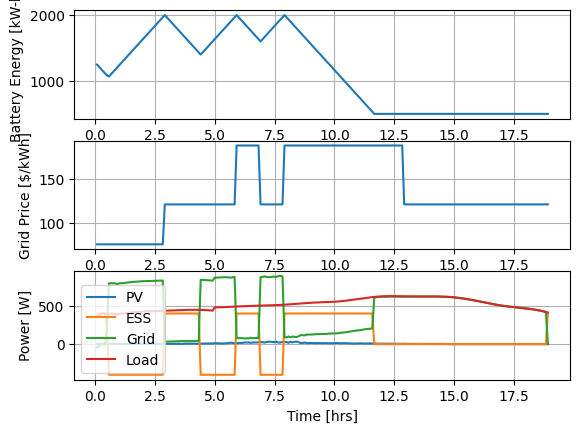

In [8]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Ebatt / 3.6e6)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Battery Energy [kW-h]')

plt.subplot(3, 1, 2)
# Assuming C is grid price
plt.plot(thour, C)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

plt.subplot(3, 1, 3)
# Assuming Ppv, Pbatt, Pgrid, Pload are obtained from battSolarOptimize
plt.plot(thour, Ppv / 1e3, thour, Pbatt / 1e3, thour, Pgrid / 1e3, thour, Pload / 1e3)
plt.grid(True)
plt.legend(['PV', 'ESS', 'Grid', 'Load'])
plt.xlabel('Time [hrs]')
plt.ylabel('Power [W]')

plt.show()


### 비용 계산

In [9]:
cumulativeCost = np.cumsum(Pgrid * (dt / 3600) * C)

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

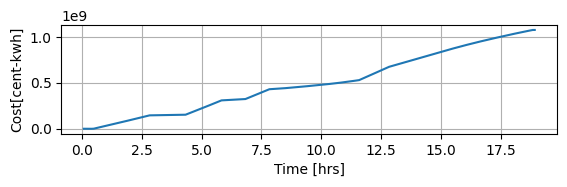

In [10]:
plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, cumulativeCost)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

In [11]:
cumulativeCost[-1] * 10e-6

10751.860841594556

In [12]:
print(Pgrid.tolist()) # 그리드에서 공급하는거
print(Pbatt.tolist()) # 배터리에서 전력 입출력 Emax, Emin 에너지 확실
print(Ebatt.tolist()) # 에너지 상태 에너지 확실
print(Pload.tolist())

[[-38896.80849793949], [-29782.07516019704], [-9730.015604885237], [1234.4314050351968], [-7988.613348174549], [196264.3335003878], [791996.3866518254], [796279.3335003878], [792026.3866518254], [796264.3335003878], [782314.7119601415], [791996.3866518254], [796264.3335003878], [796249.3335003878], [800103.4338789979], [803654.7481838312], [806796.8368110635], [809663.2601568701], [812320.0786174268], [814683.3525889092], [816676.642467493], [818583.5086493533], [820192.5115306661], [821569.7115076069], [822391.1689763513], [823195.4443330748], [823756.097973953], [825016.6902951617], [826713.2816928761], [827179.4325632721], [828123.7033025252], [828622.1543068109], [829183.3459723049], [830285.8386951828], [31410.692871620064], [32668.50992132601], [33319.54855388054], [34693.389167313], [35703.06311407883], [36679.1017466333], [37427.03641743201], [38082.398478930234], [40715.7192835834], [41570.030183846946], [39940.862532176194], [40441.24768102658], [41076.7169828536], [41727.859

In [13]:
Pload == (Ppv + Pgrid + Pbatt)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [